# Robust Adjoint Optimization for Manufacturability

> In the previous notebook, we discovered that our apodized grating is somewhat brittle: realistic ±20 nm fabrication errors can reduce efficiency by almost a decibel. A design that only works on paper is not a practical solution.

> In this final notebook we incorporate fabrication awareness directly into the adjoint optimization loop. Instead of optimizing a single, nominal simulation, we will maximize the performance across multiple fabrication corners so the resulting device maintains high efficiency even when etched dimensions shift on the wafer.

In [ ]:
import json
from copy import deepcopy
from pathlib import Path

import autograd.numpy as np
import matplotlib.pyplot as plt
import tidy3d as td
from autograd import value_and_grad
from optim import adam_update, apply_updates, clip_params, init_adam
from setup import (
    center_wavelength,
    first_gap_sin,
    get_mode_monitor_power,
    make_simulation,
    max_gap_si,
    max_gap_sin,
    max_width_si,
    max_width_sin,
    min_gap_si,
    min_gap_sin,
    min_width_si,
    min_width_sin,
)
from tidy3d import web

ETCH_BIAS = 0.02  # 20 nm fabrication bias expressed in microns.


def apply_bias(param_dict, etch_bias):
    """Return a new parameter dictionary with widths widened by bias."""
    return {
        "widths_si": param_dict["widths_si"] + etch_bias,
        "gaps_si": param_dict["gaps_si"] - etch_bias,
        "widths_sin": param_dict["widths_sin"] + etch_bias,
        "gaps_sin": param_dict["gaps_sin"] - etch_bias,
        "first_gap_si": param_dict["first_gap_si"],
        "first_gap_sin": param_dict["first_gap_sin"],
    }

## Defining a Robust Multi-Objective Function

We evaluate the design under three fabrication scenarios: nominal, over-etched (−20 nm), and under-etched (+20 nm). We then maximize the mean transmission and simultaneously minimize the standard deviation in performance between these different scenarios, which should lead to a more robust design overall. The amount of weight we place on the standard deviation minimization determines the tradeoff between nominal performance and robustness.

In [2]:
STD_PENALTY = 2.0  # Penalty for standard deviation in power


def robust_objective(params):
    freq0 = td.C_0 / center_wavelength
    scenarios = {
        "nominal": params,
        "over": apply_bias(params, -ETCH_BIAS),
        "under": apply_bias(params, ETCH_BIAS),
    }

    sims = {
        name: make_simulation(
            scenario["widths_si"],
            scenario["gaps_si"],
            scenario["widths_sin"],
            scenario["gaps_sin"],
            first_gap_si=scenario["first_gap_si"],
            first_gap_sin=scenario["first_gap_sin"],
        )
        for name, scenario in scenarios.items()
    }

    batch_data = web.run_async(sims, verbose=False, local_gradient=True)

    powers = []
    for name in ("nominal", "over", "under"):
        sim_data = batch_data[name]
        power_da = get_mode_monitor_power(sim_data)
        target_power = power_da.sel(f=freq0, method="nearest")
        powers.append(target_power.item())

    powers = np.array(powers)
    mean_power = np.mean(powers)
    variance = np.mean((powers - mean_power) ** 2)
    std_power = np.sqrt(variance)
    robust_metric = mean_power - STD_PENALTY * std_power

    return -robust_metric

### Starting Point and Bounds

We seed the optimizer with the fabrication-sensitive adjoint design and enforce the same foundry limits as before so the updates remain manufacturable.

In [3]:
data = json.loads(Path("./results/gc_adjoint_best.json").read_text(encoding="utf-8"))

num_iters = 40

params0 = {
    "widths_si": np.array(data["widths_si"], dtype=float),
    "gaps_si": np.array(data["gaps_si"], dtype=float),
    "widths_sin": np.array(data["widths_sin"], dtype=float),
    "gaps_sin": np.array(data["gaps_sin"], dtype=float),
    "first_gap_si": float(data["first_gap_si"]),
    "first_gap_sin": float(data.get("first_gap_sin", first_gap_sin)),
}

bounds = {
    "widths_si": (min_width_si, max_width_si),
    "gaps_si": (min_gap_si, max_gap_si),
    "widths_sin": (min_width_sin, max_width_sin),
    "gaps_sin": (min_gap_sin, max_gap_sin),
    "first_gap_si": (None, None),
    "first_gap_sin": (min_gap_sin, None),
}

## Running the Robust Optimization

Starting from the adjoint-optimized design found earlier, we use Adam to minimize the robust objective.

In [ ]:
vg_fun = value_and_grad(robust_objective)
params = deepcopy(params0)
opt_state = init_adam(params, lr=1e-3)

objective_history = []

for n in range(num_iters):
    value, grad = vg_fun(params)
    objective_value = -value

    objective_history.append(objective_value)
    print(f"iter {n}: objective={objective_value:.4f}")

    updates, opt_state = adam_update(grad, opt_state)
    params = apply_updates(params, updates)
    params = clip_params(params, bounds)

### Tracking Progress

Plotting the objective over iterations lets us confirm that the robust objective steadily improves (higher is better).

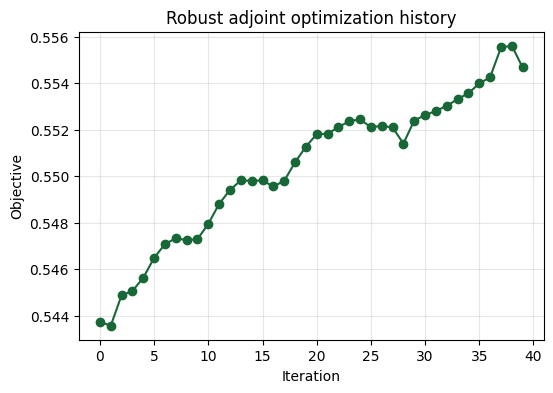

In [5]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(np.arange(len(objective_history)), objective_history, marker="o")
ax.set_xlabel("Iteration")
ax.set_ylabel("Objective")
ax.set_title("Robust adjoint optimization history")
ax.grid(True, alpha=0.3)
plt.show()

### Pre- and Post-Optimization Bias Sweeps

To visualize the payoff, we re-run the ±20 nm fabrication corners for the original and robust designs. This mirrors the analysis step from the sensitivity notebook so we can compare apples to apples.

In [6]:
def to_numpy_params(param_dict):
    """Detach autograd arrays into plain numpy arrays for analysis/export."""
    return {
        "widths_si": np.array(param_dict["widths_si"], dtype=float),
        "gaps_si": np.array(param_dict["gaps_si"], dtype=float),
        "widths_sin": np.array(param_dict["widths_sin"], dtype=float),
        "gaps_sin": np.array(param_dict["gaps_sin"], dtype=float),
        "first_gap_si": float(param_dict["first_gap_si"]),
        "first_gap_sin": float(param_dict["first_gap_sin"]),
    }


def run_bias_sweep(param_dict, task_prefix, bias=ETCH_BIAS):
    """Run nominal/over/under simulations and return spectra in linear scale."""
    scenarios = [
        ("Over-etched (-20 nm)", apply_bias(param_dict, -bias)),
        ("Nominal", param_dict),
        ("Under-etched (+20 nm)", apply_bias(param_dict, bias)),
    ]

    sims = {
        f"{task_prefix}_{idx}": make_simulation(
            scenario["widths_si"],
            scenario["gaps_si"],
            scenario["widths_sin"],
            scenario["gaps_sin"],
            first_gap_si=scenario["first_gap_si"],
            first_gap_sin=scenario["first_gap_sin"],
        )
        for idx, (_, scenario) in enumerate(scenarios)
    }

    batch_data = web.run_async(sims, verbose=False)

    wavelengths = None
    spectra = {}
    for idx, (label, _) in enumerate(scenarios):
        sim_data = batch_data[f"{task_prefix}_{idx}"]
        power_da = get_mode_monitor_power(sim_data)
        freqs = power_da.coords["f"].values
        wl = td.C_0 / freqs
        power = np.asarray(power_da.data).squeeze()
        order = np.argsort(wl)
        wl = wl[order]
        power = power[order]
        if wavelengths is None:
            wavelengths = wl
        spectra[label] = power
    return wavelengths, spectra


params_initial = to_numpy_params(params0)
params_robust = to_numpy_params(params)

w_before, spectra_before = run_bias_sweep(params_initial, "gc_robust_bias_before", bias=ETCH_BIAS)
w_after, spectra_after = run_bias_sweep(params_robust, "gc_robust_bias_after", bias=ETCH_BIAS)

## The Final Payoff: Visualizing Robustness

The left panel shows how sensitive the previous design is to ±20 nm fabrication bias, while the right panel show the spectrum after robust optimization. We can see observe a slight shift in the spectra, but to make any quantitative statement, we'll not to run another sensitivity analysis, which we'll do in the next notebook.

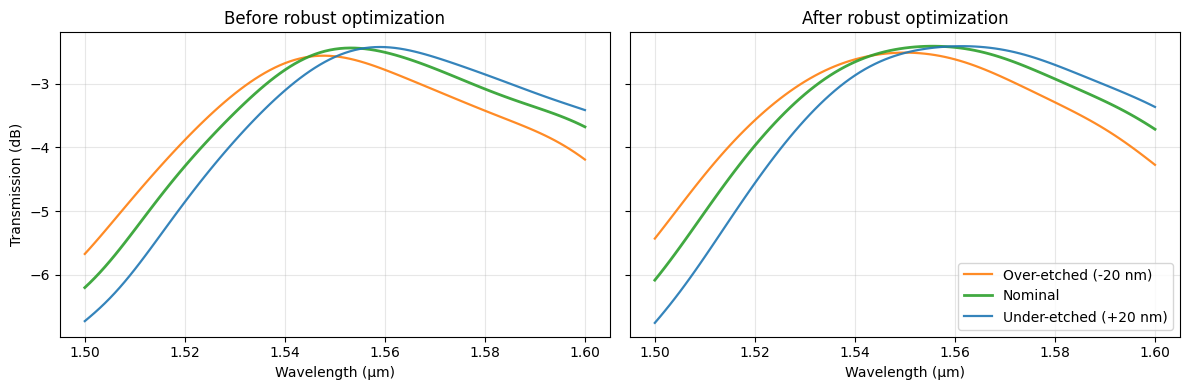

In [7]:
labels = ["Over-etched (-20 nm)", "Nominal", "Under-etched (+20 nm)"]
colors = {
    "Over-etched (-20 nm)": "tab:orange",
    "Nominal": "tab:green",
    "Under-etched (+20 nm)": "tab:blue",
}

fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

for label in labels:
    axes[0].plot(
        w_before,
        10 * np.log10(spectra_before[label]),
        label=label,
        color=colors[label],
        linewidth=2 if label == "Nominal" else 1.6,
        alpha=0.9,
    )

axes[0].set_title("Before robust optimization")
axes[0].set_xlabel("Wavelength (µm)")
axes[0].set_ylabel("Transmission (dB)")
axes[0].grid(True, alpha=0.3)

for label in labels:
    axes[1].plot(
        w_after,
        10 * np.log10(spectra_after[label]),
        label=label,
        color=colors[label],
        linewidth=2 if label == "Nominal" else 1.6,
        alpha=0.9,
    )

axes[1].set_title("After robust optimization")
axes[1].set_xlabel("Wavelength (µm)")
axes[1].grid(True, alpha=0.3)
axes[1].legend(loc="best")

plt.tight_layout()
plt.show()

### Exporting the Robust Design

Finally we save the fabrication-aware geometry so downstream notebooks - or a GDS handoff - can reuse it without re-running the optimization loop.

In [8]:
export_path = Path("./results/gc_adjoint_robust_best.json")
export_payload = {
    "widths_si": params_robust["widths_si"].tolist(),
    "gaps_si": params_robust["gaps_si"].tolist(),
    "widths_sin": params_robust["widths_sin"].tolist(),
    "gaps_sin": params_robust["gaps_sin"].tolist(),
    "first_gap_si": params_robust["first_gap_si"],
    "first_gap_sin": params_robust["first_gap_sin"],
    "etch_bias_modeled": ETCH_BIAS,
}

export_path.parent.mkdir(parents=True, exist_ok=True)
export_path.write_text(json.dumps(export_payload, indent=2), encoding="utf-8")
print(f"Saved robust design to {export_path.resolve()}")

Saved robust design to /home/yannick/flexcompute/worktrees/seminar_notebooks/docs/notebooks/2025-10-09-invdes-seminar/results/gc_adjoint_robust_best.json
